### Cell cycle

In [ ]:
import time
import timeit
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.stats import mannwhitneyu
from sklearn.neighbors import KernelDensity

# transparent background
plt.rcParams.update({
    "figure.facecolor":  (0.0, 0.0, 0.0, 0.0),  
    "axes.facecolor":    (0.0, 0.0, 0.0, 0.0),  
})

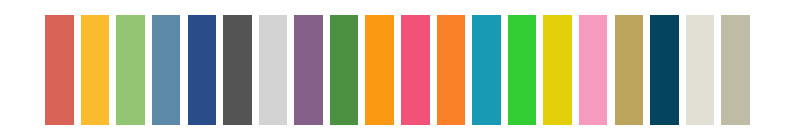

In [2]:
# define colors
purple = '#856088'
pink = '#F25278'
red = '#d96256'
lightgreen = '#93c572'
darkgreen = '#4c9141'
lightblue = '#5d8aa8'
darkblue = '#284d88'
white = '#fafafa'
lightgray = '#d3d3d3'
darkgray ='#545454'
lightorange = '#fabc2e'
darkorange = '#fb9912'
lightyellow = '#e4d00a'
lightgreen2 = '#32CD32'
lightblue2 = '#189AB4'
darkblue2 = '#05445E'
lightpink = '#F79AC0'
darkorange2 = '#FA8128'
darkyellow = '#BDA55D'
lightgray2 = '#E2E0D4'
lightgray3 = '#BFBBA4'

colors = [
    red, lightorange, lightgreen, lightblue, darkblue, 
    darkgray, lightgray, purple, darkgreen, darkorange,
    pink, darkorange2, lightblue2, lightgreen2, lightyellow,
    lightpink, darkyellow, darkblue2, lightgray2, lightgray3
]

plt.figure(figsize=(10, 1.5))
plt.bar(range(len(colors)), height=1, color=colors)
__ = plt.axis('off')

#### load data

In [3]:
# load cell cycle analysis results
path = 'input/res_saved.pkl'
with open(path, 'rb') as f:
    pickle_dict = pickle.load(f)
CC_pv_dict = pickle_dict['pv_fdr_tl']
CC_score_dict = pickle_dict['scores']
CC_lam_dict = pickle_dict['weighted_lam_est']

# load cycle analysis data
path = 'input/seqfish_data_CC_dict.pkl'
with open(path, 'rb') as f:
    data_dict = pickle.load(f)
CC_type_list = data_dict['type_list']
CC_gene_list_dict = data_dict['gene_list_dict']
CC_cell_list_dict = data_dict['cell_list_dict']
cell_mask_df = data_dict['cell_mask_df']
nuclear_mask_df = data_dict['nuclear_mask_df']
CC_data_df = data_dict['data_df']  

In [4]:
# load ella seqfish results
fn = '../ella/output_ella/ella_seqfish_np20.pkl'
res_dict = pd.read_pickle(fn)
types_list = res_dict['types_list']
genes_dict = res_dict['genes_dict']
cells_dict = res_dict['cells_dict']
kernels_list = res_dict['kernels_list']
p_fdr_dict = res_dict['p_fdr_dict']
score_dict = res_dict['score_dict']
lam_dict = res_dict['lam_dict']
label_dict = res_dict['label_dict']
del res_dict

#### check out cell cycle subclusters

In [5]:
# number of cells
for t in CC_type_list:
    print(f'{t}: #={len(CC_cell_list_dict[t])} %={len(CC_cell_list_dict[t])/len(np.concatenate(list(CC_cell_list_dict.values())))*100:.2f}')

G1: #=36 %=21.05
S: #=83 %=48.54
G2M: #=52 %=30.41


In [6]:
# find sig genes in cell cycle ella analysis
CC_sig_gl_dict = {}
for t in CC_type_list:
    pv_t = np.array(CC_pv_dict[t])
    gl_t = np.array(CC_gene_list_dict[t])
    sig_gl_t = gl_t[pv_t<=0.05]
    CC_sig_gl_dict[t] = sig_gl_t
    print(f'#={len(gl_t)} #sig={len(sig_gl_t)}')

#=756 #sig=728
#=2475 #sig=2368
#=1776 #sig=1726


In [7]:
# find patterns scores for CC_sig_gl_dict
CC_dict = {}
for t in CC_type_list:
    pv_t = np.array(CC_pv_dict[t])
    score_t = np.array(CC_score_dict[t])
    gl_t = np.array(CC_gene_list_dict[t])
    sig_gl_t = gl_t[pv_t<=0.05]
    sig_score_t = score_t[pv_t<=0.05]
    sig_lab_t = []
    for g in sig_gl_t:
        if g in genes_dict['fibroblast']:
            ig = np.where(np.array(genes_dict['fibroblast'])==g)[0][0]
            lab_g = label_dict['fibroblast'][ig]
            sig_lab_t.append(lab_g)
        else:
            sig_lab_t.append(-2)
    df_t = pd.DataFrame({
        'gene': sig_gl_t,
        'CC_score': sig_score_t,
        'label': sig_lab_t
    })
    CC_dict[t] = df_t[df_t.label>=0]

In [8]:
CC_dict[t].head(5)

,gene,CC_score,label
0,Col1a1,0.001000,1
1,Fn1,0.001000,1
2,Bgn,0.333667,2
3,Hnrnpf,0.505040,3
4,Tagln2,0.505040,3


#### ella results in each cell cycle subcluster

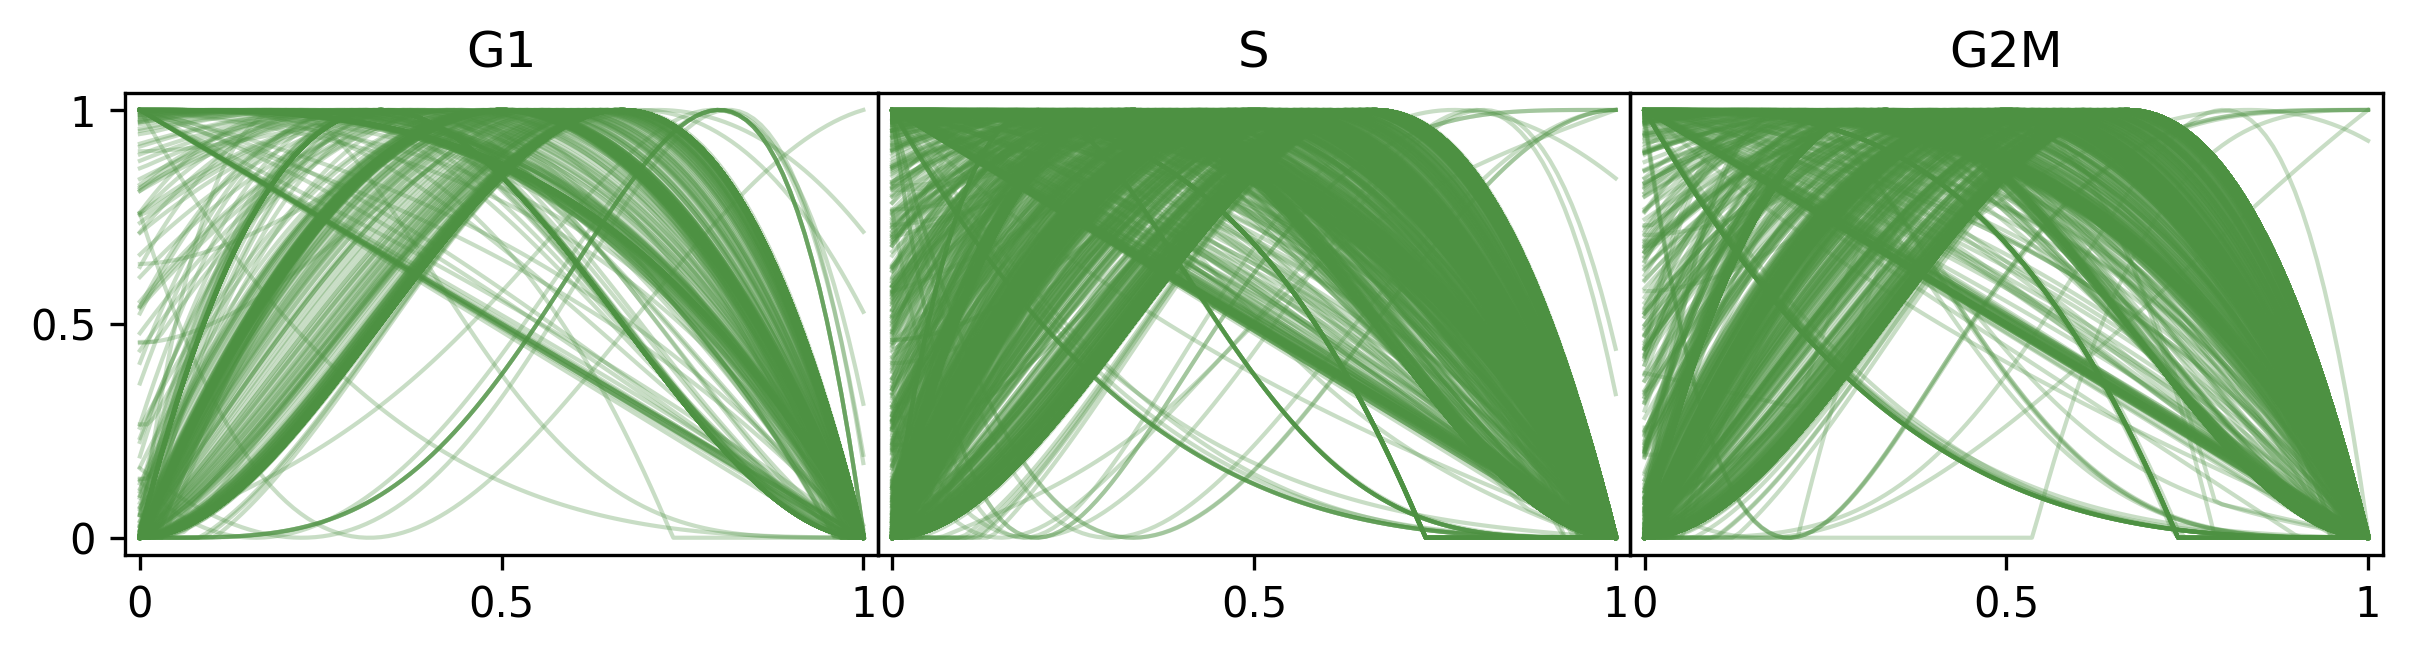

In [10]:
# lam est
x = np.linspace(0, 1, 100)

nr = 1
nc = len(CC_type_list)
ss_nc = 1.618*2
ss_nr = 2
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)

for i, t in enumerate(CC_type_list):
    ax = plt.subplot(gs[0, i])
    
    gl_cct = CC_gene_list_dict[t]
    pv_cct = CC_pv_dict[t]
    score_cct = CC_score_dict[t]
    lam_cct = CC_lam_dict[t]
    
    for j in range(len(gl_cct)):
        pv_j = pv_cct[j]
        lam_j = lam_cct[j]
        
        if pv_j <= 0.05:
            lam_std_j = (lam_j-np.min(lam_j))/(np.max(lam_j)-np.min(lam_j)) # min-max std
            ax.plot(x, lam_std_j, alpha=0.3, lw=1.0, color=darkgreen, zorder=1)

    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.04, 1.04)
    __ = ax.set_xticks([0,0.5,1], [0,0.5,1])
    __ = ax.set_yticks([0,0.5,1], [0,0.5,1])
    if i>0: ax.set_yticks([])
    ax.set_title(t)

# plt.savefig(f'figs/fig_cc_lam.pdf', dpi=300, bbox_inches='tight')

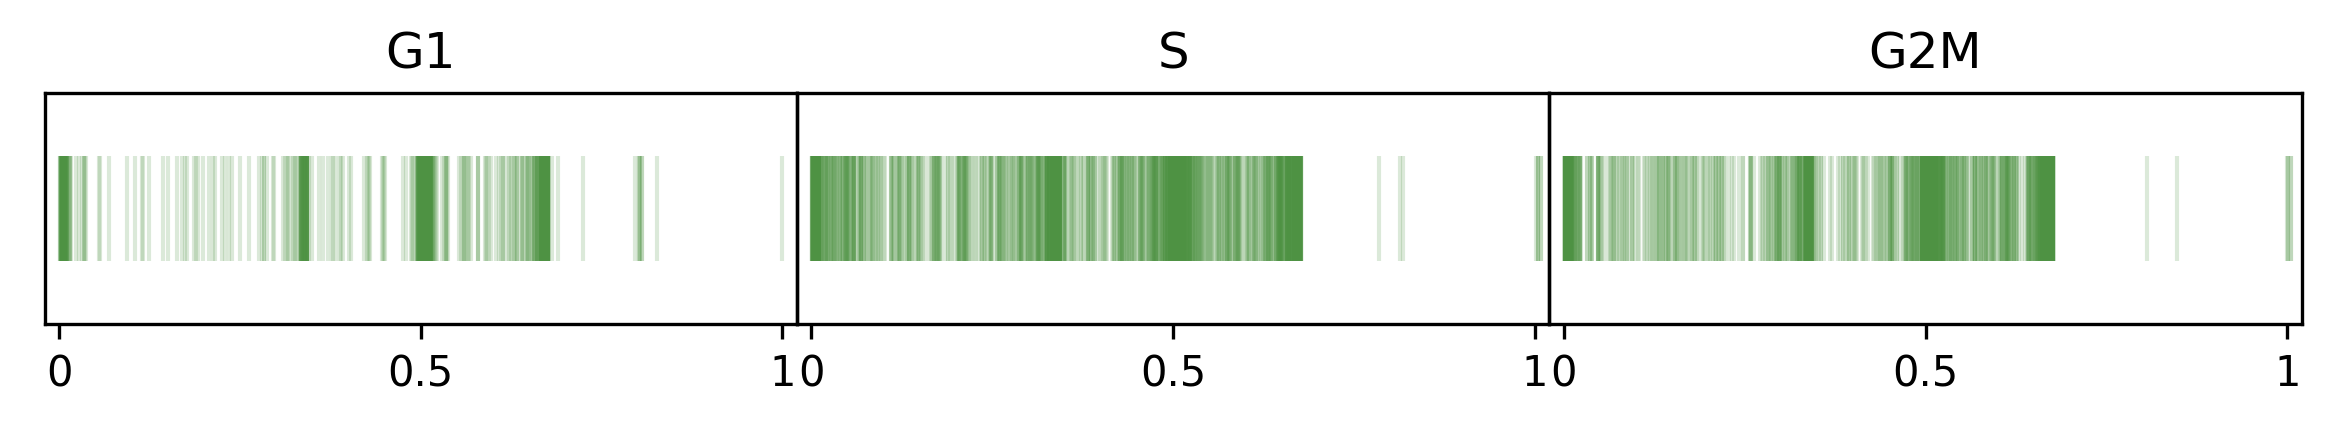

In [11]:
# score est, event plots
nr = 1
nc = len(CC_type_list)
ss_nc = 1.618*2
ss_nr = 1
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)

for i, t in enumerate(CC_type_list):
    ax = plt.subplot(gs[0, i])
    
    gl_cct = CC_gene_list_dict[t]
    pv_cct = CC_pv_dict[t]
    score_cct = CC_score_dict[t]
    lam_cct = CC_lam_dict[t]
    
    sig_score_cct = score_cct[pv_cct<=0.05]
    
    ax.eventplot([sig_score_cct + np.random.uniform(0, 0.01, len(sig_score_cct))], 
                 orientation='horizontal', 
                 colors=[darkgreen],
                 alpha=0.2,
                 linelengths=1, lw=1, lineoffsets=0)

    ax.set_xlim(-0.02, 1.02)
    __ = ax.set_xticks([0,0.5,1], [0,0.5,1])
    if j>0: ax.set_yticks([])
    ax.set_title(t)

# plt.savefig(f'figs/fig_cc_score_event.pdf', dpi=300, bbox_inches='tight')

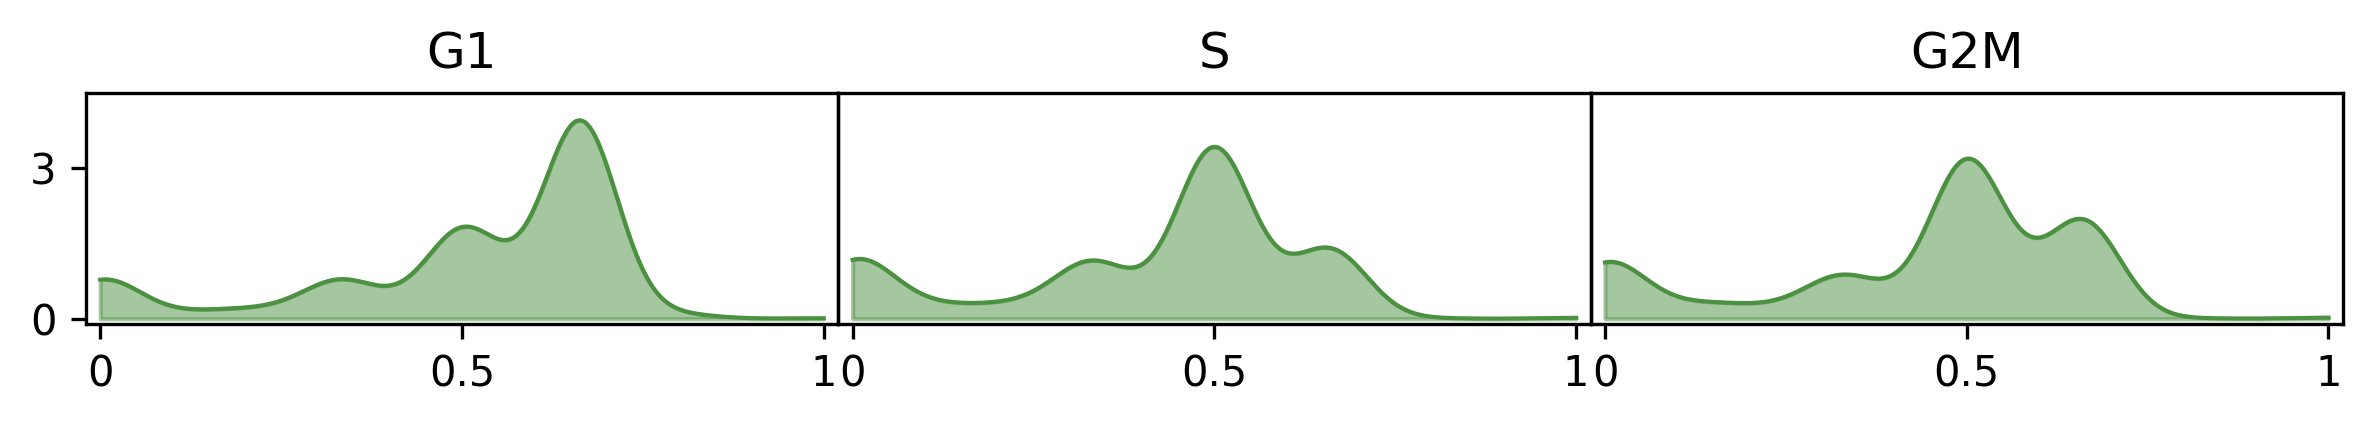

In [12]:
# score est, density plots
x = np.linspace(0, 1, 1000)

nr = 1
nc = len(CC_type_list)
ss_nc = 1.618*2
ss_nr = 1
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)

for i, t in enumerate(CC_type_list):
    ax = plt.subplot(gs[0, i])
    
    gl_cct = CC_gene_list_dict[t]
    pv_cct = CC_pv_dict[t]
    score_cct = CC_score_dict[t]
    lam_cct = CC_lam_dict[t]
    
    sig_score_cct = score_cct[pv_cct<=0.05]
    
    kde = KernelDensity(bandwidth=0.05, kernel='gaussian') # <<<
    kde.fit(sig_score_cct[:, None])
    logprob = kde.score_samples(x[:, None])
    
    ax.plot(x, np.exp(logprob), color=darkgreen, lw=1) # <<<
    ax.fill_between(x, np.exp(logprob), alpha=0.5, color=darkgreen) # <<<
    
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.1,4.5) # <<<
    __ = ax.set_xticks([0,0.5,1], [0,0.5,1])
    __ = ax.set_yticks([0,3], [0,3])
    if i>0: ax.set_yticks([])
    ax.set_title(t)

# plt.savefig(f'figs/fig_cc_score_density.pdf', dpi=300, bbox_inches='tight')

#### cc scores in each patterns

In [15]:
# across 5 patterns, test if G1 scores are larger
K_opt = 5
for k in range(K_opt):
    scores_g1 = CC_dict['G1'][CC_dict['G1'].label==k].CC_score.tolist()
    scores_else = CC_dict['S'][CC_dict['S'].label==k].CC_score.tolist() + CC_dict['G2M'][CC_dict['G2M'].label==k].CC_score.tolist()
    statistic, p_value = mannwhitneyu(scores_g1, scores_else, alternative='greater')
    print(f'----- k={k}\np={p_value}\nfold={np.mean(scores_g1)/np.mean(scores_else)}')

----- k=0
p=0.37333482687160724
fold=2.3270718139049498
----- k=1
p=0.005999316175492895
fold=1.3070020488559109
----- k=2
p=0.00014925243305230167
fold=1.123226890470107
----- k=3
p=3.5572179937762664e-67
fold=1.159204398972841
----- k=4
p=0.0014966207082679867
fold=1.0212250942211056


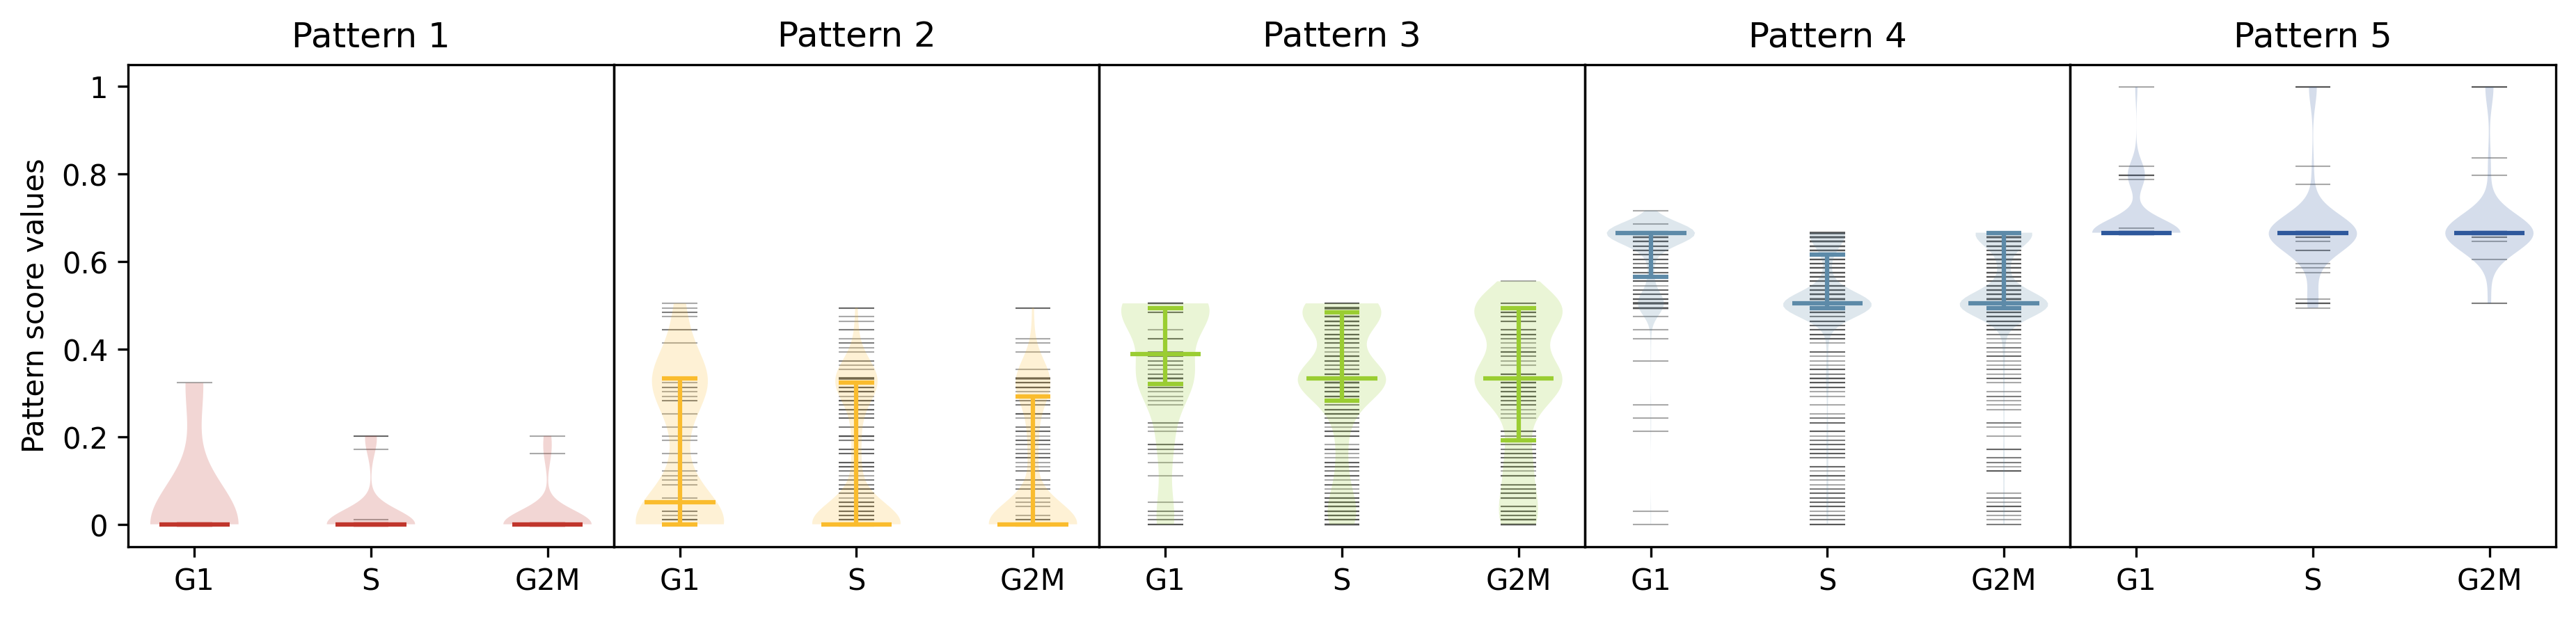

In [21]:
# initial bar plot
K_opt = 5
colors = [red, lightorange, lightgreen, lightblue, darkblue]

nr = 2
nc = K_opt
ss_nc = 3
ss_nr = 3
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0, hspace=0)

xx = np.arange(len(CC_type_list))

for k in range(K_opt):
    ax = plt.subplot(gs[0, k])
    color = colors[k]
    
    # bar plots
    data = []
    q1_list = []
    q2_list = []
    q3_list = []
    for c in CC_type_list:
        score_c = CC_dict[c][CC_dict[c].label==k].CC_score.tolist()
        data.append(score_c)
        q1_list.append(np.quantile(score_c, 0.25))
        q2_list.append(np.quantile(score_c, 0.5))
        q3_list.append(np.quantile(score_c, 0.75))
        
    # event plot
    for j in xx:
        ax.eventplot(data[j], 
                     lineoffsets=j,
                     orientation="vertical", 
                     color = darkgray,
                     zorder=1,
                     alpha=0.5,
                     linelengths=0.2,
                     linewidth=0.5)

    # violin plot
    parts = ax.violinplot(data, xx, 
                          #points=60, widths=0.7,
                          showmeans=False, 
                          showextrema=False, 
                          showmedians=False)
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('none')
        pc.set_alpha(0.2)
        
    # q1,q2,q3 in each bin
    for j in xx:
        ax.hlines(y=q1_list[j], xmin=j-0.1, xmax=j+0.1, color=color, lw=1.5)
        ax.hlines(y=q2_list[j], xmin=j-0.2, xmax=j+0.2, color=color, lw=1.5)
        ax.hlines(y=q3_list[j], xmin=j-0.1, xmax=j+0.1, color=color, lw=1.5)
        ax.vlines(x=j, ymin=q1_list[j], ymax=q3_list[j], color=color, lw=1.5)
    
    ax.set_xticks(xx, CC_type_list)
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1], [0,0.2,0.4,0.6,0.8,1])
    ax.set_ylabel('Pattern score values')
    if k>0: 
        ax.set_yticks([])
        ax.set_ylabel('')
    ax.set_title(f'Pattern {k+1}')
    
# plt.savefig(f'figs/fig_cc_pattern5_violin.pdf', dpi=300, bbox_inches='tight')

#### check common sig genes across CC

In [22]:
# com sig genes across C1, S, G2M subclusters
set1 = set(CC_sig_gl_dict['G1'])
set2 = set(CC_sig_gl_dict['S'])
set3 = set(CC_sig_gl_dict['G2M'])
cc_com_gl = list(set1.intersection(set2, set3))
print(f'com sig genes {len(cc_com_gl)}')

com sig genes 723


In [23]:
# cluster labeles of com genes
cc_com_gl_labels = []
for g in cc_com_gl:
    idx_g = np.where(np.array(genes_dict['fibroblast'])==g)
    cc_com_gl_labels.append(label_dict['fibroblast'][idx_g])
unique_elements, counts = np.unique(cc_com_gl_labels, return_counts=True)
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count} {count/len(cc_com_gl)*100:.2f}%")

0: 6 0.83%
1: 105 14.52%
2: 123 17.01%
3: 442 61.13%
4: 47 6.50%


k=0 #genes=6
['Hspg2', 'Pdgfrb', 'Ptx3', 'Sgk1', 'Slc38a2', 'Slc3a2']


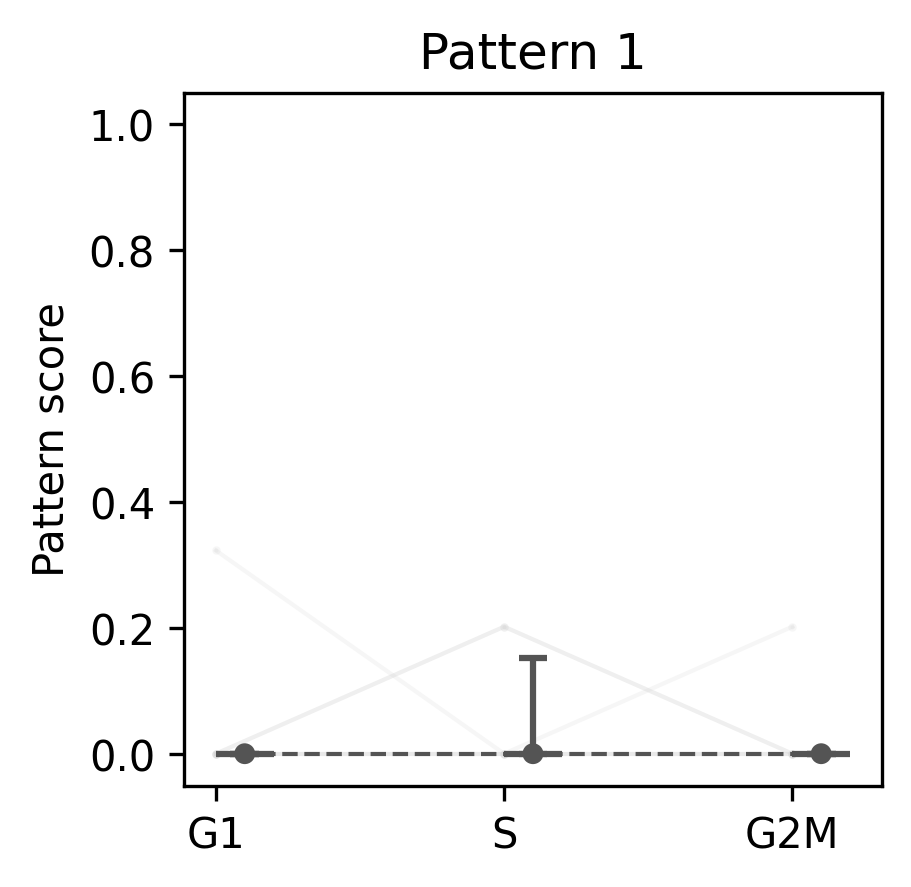

In [24]:
k = 0 # <<<

scores_k = []
for j, cc in enumerate(CC_type_list[:]):
    df_cc_ = CC_dict[cc]
    df_cc = df_cc_[df_cc_.gene.isin(cc_com_gl)]
    df_cc_k = df_cc[df_cc.label==k]
    df_cc_k = df_cc_k.sort_values(by='gene', ascending=True) # make sure genes are matched across CC    
    scores_k.append(df_cc_k.CC_score.values.tolist())
scores_k = np.array(scores_k).transpose()
scores_k_dev = scores_k[:,1:] - scores_k[:,:-1]
genes_k = df_cc_k.gene.tolist()
down_k = np.logical_and(scores_k_dev[:,0]<0, scores_k_dev[:,1]<=0).astype(int) # <<<
print(f'k={k} #genes={len(genes_k)}\n{genes_k}') # <<<

nr = 1
nc = 1
ss_nc = 3
ss_nr = 3
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.5, hspace=0.5)
ax = plt.subplot(gs[0, 0])

# ---------- lines
colors = [lightgray, red]
zorders = [1, 2]
for ig, g in enumerate(genes_k):
    ax.plot([0,1,2], scores_k[ig,:], 
            marker = '.',
            lw = 1,
            markersize=2,
            alpha=0.2, color=colors[down_k[ig]], zorder=zorders[down_k[ig]])

# ---------- overlay median etc
ll_median = 0.1
ll_q13 = 0.05
# the picked group   
color = red # <<<
q2_list = []
xx = np.array([0,1,2])
try:
    for j in range(3): 
        scores_k_j = scores_k[down_k==1,j]
        q1 = np.quantile(scores_k_j, 0.25)
        q2 = np.quantile(scores_k_j, 0.5)
        q3 = np.quantile(scores_k_j, 0.75)
        q2_list.append(q2)
        # circle at median
        ax.scatter(j, q2, 
                   marker='.', 
                   facecolors=color, 
                   edgecolors='none',
                   zorder=6,
                   s=100)
        # line at median
        ax.hlines(y=q2, xmin=j-ll_median, xmax=j+ll_median, color=color, zorder=6)
        # line at q1 and q3
        ax.hlines(y=q1, xmin=j-ll_q13, xmax=j+ll_q13, color=color, zorder=6)
        ax.hlines(y=q3, xmin=j-ll_q13, xmax=j+ll_q13, color=color, zorder=6)
        # vertical line q1-q3
        ax.vlines(x=j, ymin=q1, ymax=q3, color=color, zorder=6)
    ax.plot(xx, q2_list, linestyle='--', lw=1, color=color, zorder=5)
except:
    pass

# else
color = darkgray
shift = 0.1
q2_list = []
xx = np.array([0,1,2])
for j in range(3): 
    scores_k_j = scores_k[down_k==0,j]
    q1 = np.quantile(scores_k_j, 0.25)
    q2 = np.quantile(scores_k_j, 0.5)
    q3 = np.quantile(scores_k_j, 0.75)
    q2_list.append(q2)
    # circle at median
    ax.scatter(j+shift, q2, 
               marker='.', 
               facecolors=color, 
               edgecolors='none',
               zorder=4,
               s=100)
    # line at median
    ax.hlines(y=q2, xmin=j-ll_median+shift, xmax=j+ll_median+shift, color=color, zorder=4)
    # line at q1 and q3
    ax.hlines(y=q1, xmin=j-ll_q13+shift, xmax=j+ll_q13+shift, color=color, zorder=4)
    ax.hlines(y=q3, xmin=j-ll_q13+shift, xmax=j+ll_q13+shift, color=color, zorder=4)
    # vertical line q1-q3
    ax.vlines(x=j+shift, ymin=q1, ymax=q3, color=color, zorder=4)
ax.plot(xx, q2_list, linestyle='--', lw=1, color=color, zorder=3)

# ---------- p
try:
    ylim = ax.get_ylim()
    for j in range(3): 
        sample1 = scores_k[down_k==1,j]
        sample2 = scores_k[down_k==0,j]
        __statistic, p_value1 = mannwhitneyu(sample1, sample2)
        ax.text(j+shift/2, max(np.quantile(sample1, 0.75), np.quantile(sample2, 0.75)) + 0.05*(ylim[1]-ylim[0]), 
                f'{p_value1:.2f}',
                horizontalalignment='center')
except:
    pass

ax.set_title(f'Pattern {k+1}')
ax.set_xticks([0,1,2], CC_type_list)
ax.set_ylabel('Pattern score')
ax.set_ylim(-0.05, 1.05)

# plt.savefig(f'figs/fig_cc_com_pattern{k+1}.pdf', dpi=300, bbox_inches='tight')

k=1 #genes=105


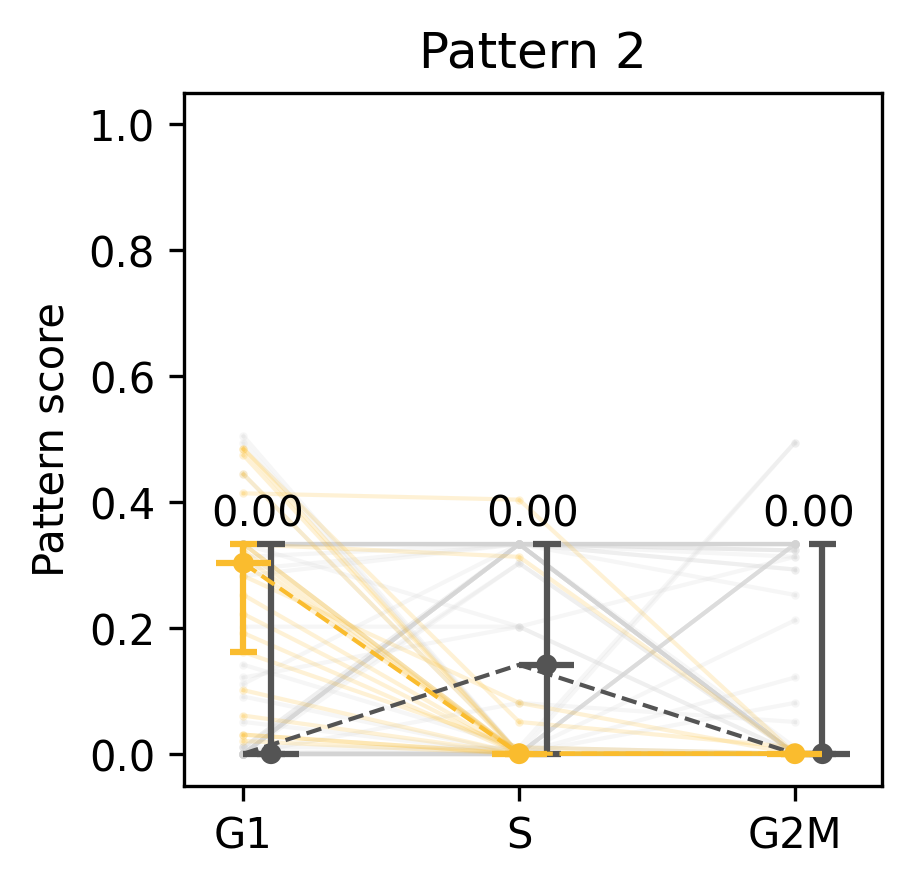

In [26]:
k = 1 # <<<

scores_k = []
for j, cc in enumerate(CC_type_list[:]):
    df_cc_ = CC_dict[cc]
    df_cc = df_cc_[df_cc_.gene.isin(cc_com_gl)]
    df_cc_k = df_cc[df_cc.label==k]
    df_cc_k = df_cc_k.sort_values(by='gene', ascending=True) # make sure genes are matched across CC    
    scores_k.append(df_cc_k.CC_score.values.tolist())
scores_k = np.array(scores_k).transpose()
scores_k_dev = scores_k[:,1:] - scores_k[:,:-1]
genes_k = df_cc_k.gene.tolist()
down_k = np.logical_and(scores_k_dev[:,0]<0, scores_k_dev[:,1]<=0).astype(int) # <<<
print(f'k={k} #genes={len(genes_k)}') 

nr = 1
nc = 1
ss_nc = 3
ss_nr = 3
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.5, hspace=0.5)
ax = plt.subplot(gs[0, 0])

# ---------- lines
colors = [lightgray, lightorange] # <<<
zorders = [1, 2]
for ig, g in enumerate(genes_k):
    ax.plot([0,1,2], scores_k[ig,:], 
            marker = '.',
            lw = 1,
            markersize=2,
            alpha=0.2, color=colors[down_k[ig]], zorder=zorders[down_k[ig]])

# ---------- overlay median etc
ll_median = 0.1
ll_q13 = 0.05
# the picked group   
color = lightorange # <<<
q2_list = []
xx = np.array([0,1,2])
for j in range(3): 
    scores_k_j = scores_k[down_k==1,j]
    q1 = np.quantile(scores_k_j, 0.25)
    q2 = np.quantile(scores_k_j, 0.5)
    q3 = np.quantile(scores_k_j, 0.75)
    q2_list.append(q2)
    # circle at median
    ax.scatter(j, q2, 
               marker='.', 
               facecolors=color, 
               edgecolors='none',
               zorder=6,
               s=100)
    # line at median
    ax.hlines(y=q2, xmin=j-ll_median, xmax=j+ll_median, color=color, zorder=6)
    # line at q1 and q3
    ax.hlines(y=q1, xmin=j-ll_q13, xmax=j+ll_q13, color=color, zorder=6)
    ax.hlines(y=q3, xmin=j-ll_q13, xmax=j+ll_q13, color=color, zorder=6)
    # vertical line q1-q3
    ax.vlines(x=j, ymin=q1, ymax=q3, color=color, zorder=6)
ax.plot(xx, q2_list, linestyle='--', lw=1, color=color, zorder=5)

# else
color = darkgray
shift = 0.1
q2_list = []
xx = np.array([0,1,2])
for j in range(3): 
    scores_k_j = scores_k[down_k==0,j]
    q1 = np.quantile(scores_k_j, 0.25)
    q2 = np.quantile(scores_k_j, 0.5)
    q3 = np.quantile(scores_k_j, 0.75)
    q2_list.append(q2)
    # circle at median
    ax.scatter(j+shift, q2, 
               marker='.', 
               facecolors=color, 
               edgecolors='none',
               zorder=4,
               s=100)
    # line at median
    ax.hlines(y=q2, xmin=j-ll_median+shift, xmax=j+ll_median+shift, color=color, zorder=4)
    # line at q1 and q3
    ax.hlines(y=q1, xmin=j-ll_q13+shift, xmax=j+ll_q13+shift, color=color, zorder=4)
    ax.hlines(y=q3, xmin=j-ll_q13+shift, xmax=j+ll_q13+shift, color=color, zorder=4)
    # vertical line q1-q3
    ax.vlines(x=j+shift, ymin=q1, ymax=q3, color=color, zorder=4)
ax.plot(xx, q2_list, linestyle='--', lw=1, color=color, zorder=3)

# ---------- p
ylim = ax.get_ylim()
for j in range(3): 
    sample1 = scores_k[down_k==1,j]
    sample2 = scores_k[down_k==0,j]
    __statistic, p_value1 = mannwhitneyu(sample1, sample2)
    ax.text(j+shift/2, max(np.quantile(sample1, 0.75), np.quantile(sample2, 0.75)) + 0.05*(ylim[1]-ylim[0]), 
            f'{p_value1:.2f}',
            horizontalalignment='center')
    
ax.set_title(f'Pattern {k+1}')
ax.set_xticks([0,1,2], CC_type_list)
ax.set_ylabel('Pattern score')
ax.set_ylim(-0.05, 1.05)

# plt.savefig(f'figs/fig_cc_com_pattern{k+1}.pdf', dpi=300, bbox_inches='tight')

k=2 #genes=123


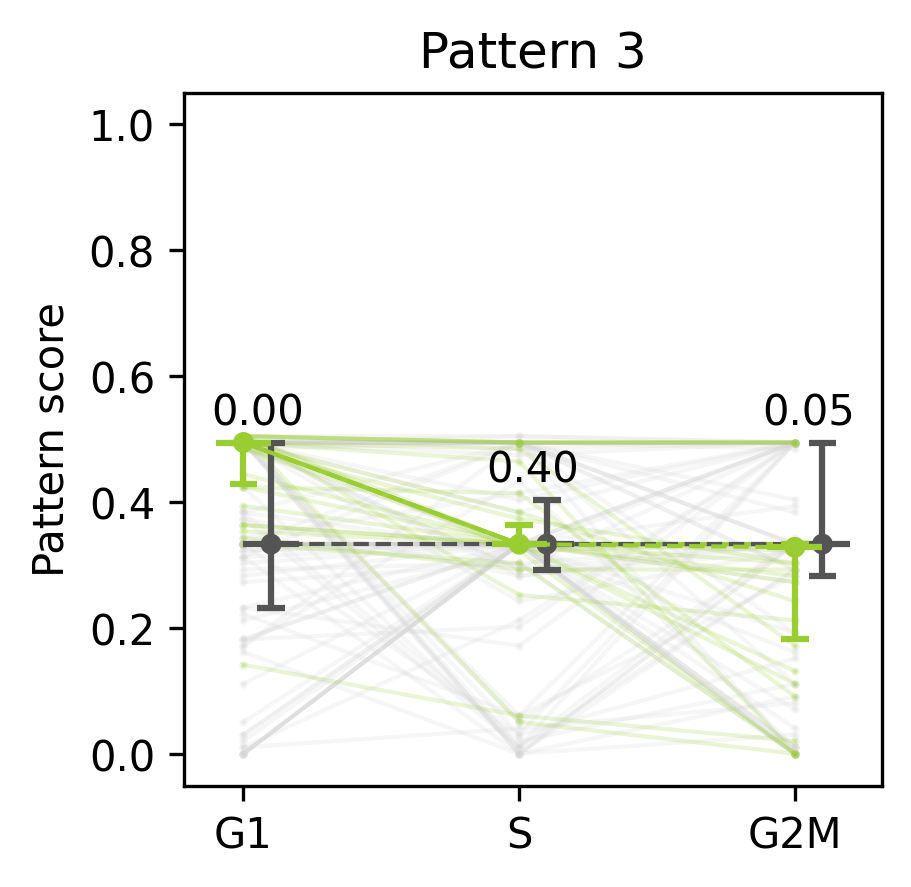

In [27]:
k = 2 # <<<

scores_k = []
for j, cc in enumerate(CC_type_list[:]):
    df_cc_ = CC_dict[cc]
    df_cc = df_cc_[df_cc_.gene.isin(cc_com_gl)]
    df_cc_k = df_cc[df_cc.label==k]
    df_cc_k = df_cc_k.sort_values(by='gene', ascending=True) # make sure genes are matched across CC    
    scores_k.append(df_cc_k.CC_score.values.tolist())
scores_k = np.array(scores_k).transpose()
scores_k_dev = scores_k[:,1:] - scores_k[:,:-1]
genes_k = df_cc_k.gene.tolist()
down_k = np.logical_and(scores_k_dev[:,0]<0, scores_k_dev[:,1]<=0).astype(int) # <<<
print(f'k={k} #genes={len(genes_k)}')

nr = 1
nc = 1
ss_nc = 3
ss_nr = 3
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.5, hspace=0.5)
ax = plt.subplot(gs[0, 0])

# ---------- lines
colors = [lightgray, lightgreen] # <<<
zorders = [1, 2]
for ig, g in enumerate(genes_k):
    ax.plot([0,1,2], scores_k[ig,:], 
            marker = '.',
            lw = 1,
            markersize=2,
            alpha=0.2, color=colors[down_k[ig]], zorder=zorders[down_k[ig]])

# ---------- overlay median etc
ll_median = 0.1
ll_q13 = 0.05
# the picked group   
color = lightgreen # <<<
q2_list = []
xx = np.array([0,1,2])
for j in range(3): 
    scores_k_j = scores_k[down_k==1,j]
    q1 = np.quantile(scores_k_j, 0.25)
    q2 = np.quantile(scores_k_j, 0.5)
    q3 = np.quantile(scores_k_j, 0.75)
    q2_list.append(q2)
    # circle at median
    ax.scatter(j, q2, 
               marker='.', 
               facecolors=color, 
               edgecolors='none',
               zorder=6,
               s=100)
    # line at median
    ax.hlines(y=q2, xmin=j-ll_median, xmax=j+ll_median, color=color, zorder=6)
    # line at q1 and q3
    ax.hlines(y=q1, xmin=j-ll_q13, xmax=j+ll_q13, color=color, zorder=6)
    ax.hlines(y=q3, xmin=j-ll_q13, xmax=j+ll_q13, color=color, zorder=6)
    # vertical line q1-q3
    ax.vlines(x=j, ymin=q1, ymax=q3, color=color, zorder=6)
ax.plot(xx, q2_list, linestyle='--', lw=1, color=color, zorder=5)

# else
color = darkgray
shift = 0.1
q2_list = []
xx = np.array([0,1,2])
for j in range(3): 
    scores_k_j = scores_k[down_k==0,j]
    q1 = np.quantile(scores_k_j, 0.25)
    q2 = np.quantile(scores_k_j, 0.5)
    q3 = np.quantile(scores_k_j, 0.75)
    q2_list.append(q2)
    # circle at median
    ax.scatter(j+shift, q2, 
               marker='.', 
               facecolors=color, 
               edgecolors='none',
               zorder=4,
               s=100)
    # line at median
    ax.hlines(y=q2, xmin=j-ll_median+shift, xmax=j+ll_median+shift, color=color, zorder=4)
    # line at q1 and q3
    ax.hlines(y=q1, xmin=j-ll_q13+shift, xmax=j+ll_q13+shift, color=color, zorder=4)
    ax.hlines(y=q3, xmin=j-ll_q13+shift, xmax=j+ll_q13+shift, color=color, zorder=4)
    # vertical line q1-q3
    ax.vlines(x=j+shift, ymin=q1, ymax=q3, color=color, zorder=4)
ax.plot(xx, q2_list, linestyle='--', lw=1, color=color, zorder=3)

# ---------- p
ylim = ax.get_ylim()
for j in range(3): 
    sample1 = scores_k[down_k==1,j]
    sample2 = scores_k[down_k==0,j]
    __statistic, p_value1 = mannwhitneyu(sample1, sample2)
    ax.text(j+shift/2, max(np.quantile(sample1, 0.75), np.quantile(sample2, 0.75)) + 0.05*(ylim[1]-ylim[0]), 
            f'{p_value1:.2f}',
            horizontalalignment='center')
    
ax.set_title(f'Pattern {k+1}')
ax.set_xticks([0,1,2], CC_type_list)
ax.set_ylabel('Pattern score')
ax.set_ylim(-0.05, 1.05)

# plt.savefig(f'figs/fig_cc_com_pattern{k+1}.pdf', dpi=300, bbox_inches='tight')

k=3 #genes=442


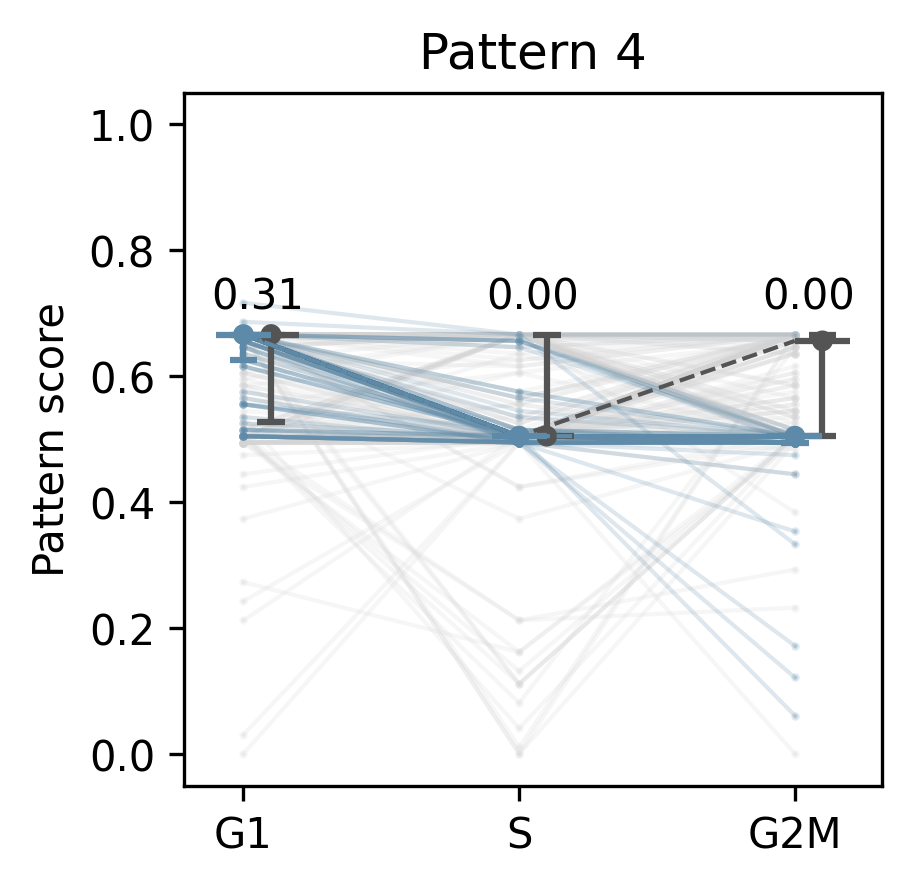

In [28]:
k = 3 # <<<

scores_k = []
for j, cc in enumerate(CC_type_list[:]):
    df_cc_ = CC_dict[cc]
    df_cc = df_cc_[df_cc_.gene.isin(cc_com_gl)]
    df_cc_k = df_cc[df_cc.label==k]
    df_cc_k = df_cc_k.sort_values(by='gene', ascending=True) # make sure genes are matched across CC    
    scores_k.append(df_cc_k.CC_score.values.tolist())
scores_k = np.array(scores_k).transpose()
scores_k_dev = scores_k[:,1:] - scores_k[:,:-1]
genes_k = df_cc_k.gene.tolist()
down_k = np.logical_and(scores_k_dev[:,0]<0, scores_k_dev[:,1]<=0).astype(int) # <<<
print(f'k={k} #genes={len(genes_k)}')

nr = 1
nc = 1
ss_nc = 3
ss_nr = 3
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.5, hspace=0.5)
ax = plt.subplot(gs[0, 0])

# ---------- lines
colors = [lightgray, lightblue] # <<<
zorders = [1, 2]
for ig, g in enumerate(genes_k):
    ax.plot([0,1,2], scores_k[ig,:], 
            marker = '.',
            lw = 1,
            markersize=2,
            alpha=0.2, color=colors[down_k[ig]], zorder=zorders[down_k[ig]])

# ---------- overlay median etc
ll_median = 0.1
ll_q13 = 0.05
# the picked group   
color = lightblue # <<<
q2_list = []
xx = np.array([0,1,2])
for j in range(3): 
    scores_k_j = scores_k[down_k==1,j]
    q1 = np.quantile(scores_k_j, 0.25)
    q2 = np.quantile(scores_k_j, 0.5)
    q3 = np.quantile(scores_k_j, 0.75)
    q2_list.append(q2)
    # circle at median
    ax.scatter(j, q2, 
               marker='.', 
               facecolors=color, 
               edgecolors='none',
               zorder=6,
               s=100)
    # line at median
    ax.hlines(y=q2, xmin=j-ll_median, xmax=j+ll_median, color=color, zorder=6)
    # line at q1 and q3
    ax.hlines(y=q1, xmin=j-ll_q13, xmax=j+ll_q13, color=color, zorder=6)
    ax.hlines(y=q3, xmin=j-ll_q13, xmax=j+ll_q13, color=color, zorder=6)
    # vertical line q1-q3
    ax.vlines(x=j, ymin=q1, ymax=q3, color=color, zorder=6)
ax.plot(xx, q2_list, linestyle='--', lw=1, color=color, zorder=5)

# else
color = darkgray
shift = 0.1
q2_list = []
xx = np.array([0,1,2])
for j in range(3): 
    scores_k_j = scores_k[down_k==0,j]
    q1 = np.quantile(scores_k_j, 0.25)
    q2 = np.quantile(scores_k_j, 0.5)
    q3 = np.quantile(scores_k_j, 0.75)
    q2_list.append(q2)
    # circle at median
    ax.scatter(j+shift, q2, 
               marker='.', 
               facecolors=color, 
               edgecolors='none',
               zorder=4,
               s=100)
    # line at median
    ax.hlines(y=q2, xmin=j-ll_median+shift, xmax=j+ll_median+shift, color=color, zorder=4)
    # line at q1 and q3
    ax.hlines(y=q1, xmin=j-ll_q13+shift, xmax=j+ll_q13+shift, color=color, zorder=4)
    ax.hlines(y=q3, xmin=j-ll_q13+shift, xmax=j+ll_q13+shift, color=color, zorder=4)
    # vertical line q1-q3
    ax.vlines(x=j+shift, ymin=q1, ymax=q3, color=color, zorder=4)
ax.plot(xx, q2_list, linestyle='--', lw=1, color=color, zorder=3)

# ---------- p
ylim = ax.get_ylim()
for j in range(3): 
    sample1 = scores_k[down_k==1,j]
    sample2 = scores_k[down_k==0,j]
    __statistic, p_value1 = mannwhitneyu(sample1, sample2)
    ax.text(j+shift/2, max(np.quantile(sample1, 0.75), np.quantile(sample2, 0.75)) + 0.05*(ylim[1]-ylim[0]), 
            f'{p_value1:.2f}',
            horizontalalignment='center')
    
ax.set_title(f'Pattern {k+1}')
ax.set_xticks([0,1,2], CC_type_list)
ax.set_ylabel('Pattern score')
ax.set_ylim(-0.05, 1.05)

# plt.savefig(f'figs/fig_cc_com_pattern{k+1}.pdf', dpi=300, bbox_inches='tight')

k=4 #genes=47


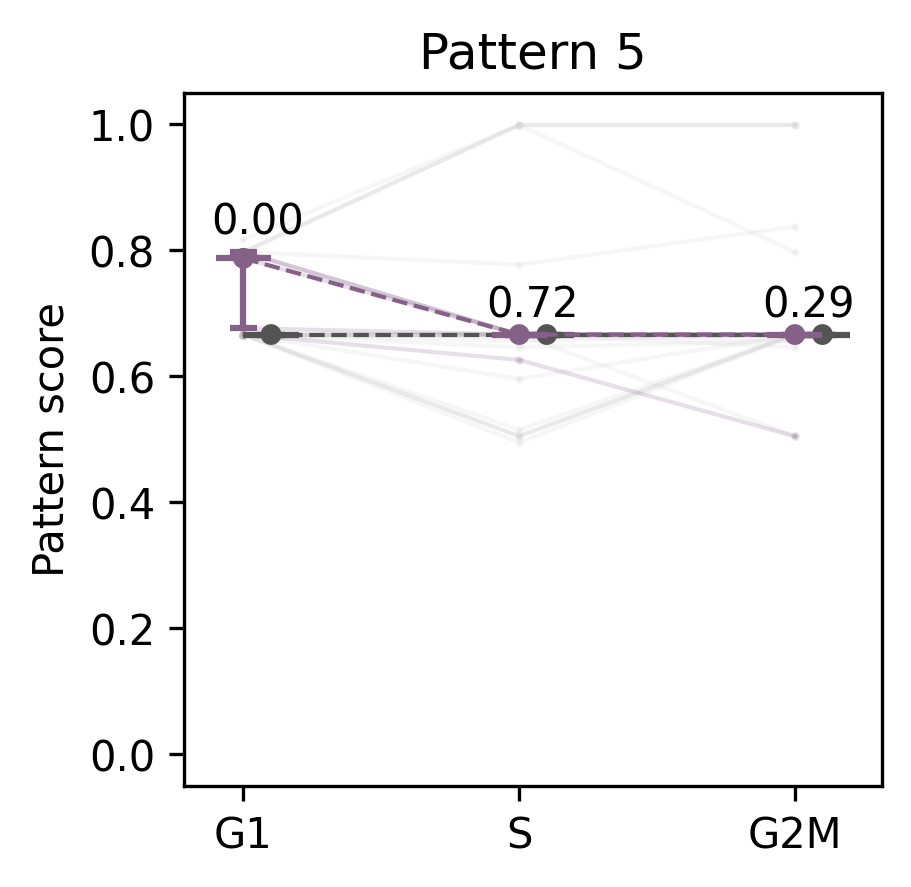

In [121]:
k = 4 # <<<

scores_k = []
for j, cc in enumerate(CC_type_list[:]):
    df_cc_ = CC_dict[cc]
    df_cc = df_cc_[df_cc_.gene.isin(cc_com_gl)]
    df_cc_k = df_cc[df_cc.label==k]
    df_cc_k = df_cc_k.sort_values(by='gene', ascending=True) # make sure genes are matched across CC    
    scores_k.append(df_cc_k.CC_score.values.tolist())
scores_k = np.array(scores_k).transpose()
scores_k_dev = scores_k[:,1:] - scores_k[:,:-1]
genes_k = df_cc_k.gene.tolist()
down_k = np.logical_and(scores_k_dev[:,0]<0, scores_k_dev[:,1]<=0).astype(int) # <<<
print(f'k={k} #genes={len(genes_k)}')

nr = 1
nc = 1
ss_nc = 3
ss_nr = 3
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.5, hspace=0.5)
ax = plt.subplot(gs[0, 0])

# ---------- lines
colors = [lightgray, darkblue] # <<<
zorders = [1, 2]
for ig, g in enumerate(genes_k):
    ax.plot([0,1,2], scores_k[ig,:], 
            marker = '.',
            lw = 1,
            markersize=2,
            alpha=0.2, color=colors[down_k[ig]], zorder=zorders[down_k[ig]])

# ---------- overlay median etc
ll_median = 0.1
ll_q13 = 0.05
# the picked group   
color = darkblue # <<<
q2_list = []
xx = np.array([0,1,2])
for j in range(3): 
    scores_k_j = scores_k[down_k==1,j]
    q1 = np.quantile(scores_k_j, 0.25)
    q2 = np.quantile(scores_k_j, 0.5)
    q3 = np.quantile(scores_k_j, 0.75)
    q2_list.append(q2)
    # circle at median
    ax.scatter(j, q2, 
               marker='.', 
               facecolors=color, 
               edgecolors='none',
               zorder=6,
               s=100)
    # line at median
    ax.hlines(y=q2, xmin=j-ll_median, xmax=j+ll_median, color=color, zorder=6)
    # line at q1 and q3
    ax.hlines(y=q1, xmin=j-ll_q13, xmax=j+ll_q13, color=color, zorder=6)
    ax.hlines(y=q3, xmin=j-ll_q13, xmax=j+ll_q13, color=color, zorder=6)
    # vertical line q1-q3
    ax.vlines(x=j, ymin=q1, ymax=q3, color=color, zorder=6)
ax.plot(xx, q2_list, linestyle='--', lw=1, color=color, zorder=5)

# else
color = darkgray
shift = 0.1
q2_list = []
xx = np.array([0,1,2])
for j in range(3): 
    scores_k_j = scores_k[down_k==0,j]
    q1 = np.quantile(scores_k_j, 0.25)
    q2 = np.quantile(scores_k_j, 0.5)
    q3 = np.quantile(scores_k_j, 0.75)
    q2_list.append(q2)
    # circle at median
    ax.scatter(j+shift, q2, 
               marker='.', 
               facecolors=color, 
               edgecolors='none',
               zorder=4,
               s=100)
    # line at median
    ax.hlines(y=q2, xmin=j-ll_median+shift, xmax=j+ll_median+shift, color=color, zorder=4)
    # line at q1 and q3
    ax.hlines(y=q1, xmin=j-ll_q13+shift, xmax=j+ll_q13+shift, color=color, zorder=4)
    ax.hlines(y=q3, xmin=j-ll_q13+shift, xmax=j+ll_q13+shift, color=color, zorder=4)
    # vertical line q1-q3
    ax.vlines(x=j+shift, ymin=q1, ymax=q3, color=color, zorder=4)
ax.plot(xx, q2_list, linestyle='--', lw=1, color=color, zorder=3)

# ---------- p
ylim = ax.get_ylim()
for j in range(3): 
    sample1 = scores_k[down_k==1,j]
    sample2 = scores_k[down_k==0,j]
    __statistic, p_value1 = mannwhitneyu(sample1, sample2)
    ax.text(j+shift/2, max(np.quantile(sample1, 0.75), np.quantile(sample2, 0.75)) + 0.05*(ylim[1]-ylim[0]), 
            f'{p_value1:.2f}',
            horizontalalignment='center')
    
ax.set_title(f'Pattern {k+1}')
ax.set_xticks([0,1,2], CC_type_list)
ax.set_ylabel('Pattern score')
ax.set_ylim(-0.05, 1.05)

# plt.savefig(f'figs/fig_cc_com_pattern{k+1}.pdf', dpi=300, bbox_inches='tight')